# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к Data Mining этот процесс называется Extract-Transform-Load

In [1]:
!pip install -r requirements.txt

  Running setup.py bdist_wheel for vk ... - \ done
  Stored in directory: /home/artyoms/.cache/pip/wheels/8d/e2/0c/056e125d54b4c9b2830ca6a7e6de00b36d416775da969abb94
Successfully built vk


In [1]:
import vk
import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Нам потребуется загрузить информацию о местах, в которых совершаются чекины, иначе говоря провести сбор данных (data collection). [Ссылка на ВК для разработчиков](https://vk.com/dev)

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в VK в качестве разработчика и создать свое [приложение](https://vk.com/apps?act=manage). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Далее вам потребуется создать токен авторизации, чтобы получать доступ к API. Этот токен необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в VK API можно почитать [по ссылке](https://vk.com/dev/first_guide), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
ACCESS_TOKEN = "dbe01992331f7d49eb88950126aaf0b12b04be51e22cac325d329805c4d78fcdcc586961c0f8347819f5f"
session = vk.Session(access_token=ACCESS_TOKEN)
vkapi = vk.API(session=session)

In [5]:
# Проверка, что всё работает
print vkapi.getServerTime()
print vk.version


1489184373
2.0.2


VK API может отдавать вам посещаемые места несколькими способами: в некотором радиусе от точки или же по id самого места. Мы будем пользоваться [вторым способом](https://vk.com/dev/places.getById) . Требуется написать функцию, которая на вход получает объект подключения к API и индекс, до какого объекта требуется запросить. Возвращать она будет pandas.DataFrame с полученными данными.

In [6]:
def get_place_info(vkapi, idx=5000):
    current_idx = 1
    frames = []
    while(current_idx < idx):
        if current_idx + 1000 < idx:    
            places_id = range(current_idx,current_idx + 1001,1)
        else:
            places_id = range(current_idx,idx+1,1)
            
        current_idx +=1001
        places_list = vkapi.places.getById(places=places_id)
        frames.append(pd.DataFrame({"Title": [place['title'] for place in places_list], 
                         "Latitude":[place['latitude'] for place in places_list],
                         "Longitude":[place['longitude'] for place in places_list],
                         "Created":[place['created'] for place in places_list],
                         "Checkins":[place['checkins'] for place in places_list],
                         "Type":[place['type'] for place in places_list], 
                         "Country":[place['country'] for place in places_list], 
                         "City":[place['city'] for place in places_list], 
                         "Address":[place['address'] for place in places_list]},
                         index=[place['pid'] for place in places_list]))
        
    return pd.concat(frames)

Предположим, что мы хотим понять несколько фактов о выборке объектов с id от 1 до 5000.
Помогите нам это сделать.
А вот и сами факты:
1. Провизуализируйте на карте все объекты которые находятся в Москве? Где больше объектов, в центре или на окраине?
2. Посчитайте количество объектов разного типа. Постройте распределение? Объектов какого типа больше в данной выборке?
3. Посчитайте распределение числа чекинов по всей выборке. Визуализируйте его.
4. Постройте box plot по числу чекинов для каждого типа объектов.
5. Преобразуйте поле created в datetime. Как давно были созданы объекты? Сколько объектов существует больше года? 

Не забудьте сохранить данную выборку, в будущем она вам понадобится.

In [7]:
data = get_place_info(vkapi=vkapi, idx=5000)

In [10]:
#Запись сета данных
data.to_csv('full_set.csv', encoding='utf-8')

In [11]:
# Визуализация
mos_center = [55.750475, 37.619020]
mos_min_lat, mos_max_lat = 55.564141, 55.908930
mos_min_lon, mos_max_lon = 37.344362, 37.879945

In [13]:
data_moscow = data[data.Latitude.between(mos_min_lat, mos_max_lat) &
                   data.Longitude.between(mos_min_lon, mos_max_lon)]

In [14]:
data.shape, data_moscow.shape

((5000, 9), (1671, 9))

In [15]:
moscow = folium.Map(location=mos_center, zoom_start=11, control_scale=True)

In [18]:
from folium.plugins import MarkerCluster
%matplotlib inline
marker_cluster = MarkerCluster(locations=data_moscow[['Latitude', 'Longitude']].values)

In [19]:
marker_cluster.add_to(moscow)

In [20]:
moscow

И тут-то мы ступаем на скользкую дорожку. Нужно определить, что такое центр и что такое не центр. Давайте условно разобьём на три категории по удалённости от центра: в пределах Садового кольца, в пределах Третьего траснпортного кольца, за его пределами. 
Садовое кольцо: самая северная точка - 55.773869(Садово-Самотёчная улица), южная - 55.729632(Добрынинский тоннель), запад - 37.582375 (Смоленская площадь), восток - 37.657259(улица Земляной вал. 
Третье транспортное: северyfz njxrf - 55.792975(метро Марьина Роща), южная - 55.701178(Чурская эстакада), 
запад - 37.535292 (метро Кутузовская), восток - 37.699619(Шоссе энтузиастов)

In [24]:
# И тут та такой понимаешь, что folium - это круто
sadovoe_min_lat, sadovoe_max_lat = 55.729632, 55.773869
sadovoe_min_lon, sadovoe_max_lon = 37.582375, 37.657259
ttring_min_lat, ttring_max_lat = 55.701178, 55.792975
ttring_min_lon, ttring_max_lon = 37.535292, 37.699619

In [28]:
in_sadovoe =  len(data[data.Latitude.between(sadovoe_min_lat, sadovoe_max_lat) &
                   data.Longitude.between(sadovoe_min_lon, sadovoe_max_lon)])
out_sadovoe = 1671 - in_sadovoe

In [29]:
in_ttring =  len(data[data.Latitude.between(ttring_min_lat, ttring_max_lat) &
                   data.Longitude.between(ttring_min_lon, ttring_max_lon)])
out_ttring = 1671 - in_ttring

In [30]:
print in_sadovoe, in_ttring - in_sadovoe, out_ttring

619 432 620


Соответственно, в зависимости от того, что считаем границей "в цетнре" - Садовое или Третье транспортное, в центре меньше на 1052, в центре больше на 431 объект.

In [32]:
types_set = set(data["Type"])
types_set

{3, 4}

In [36]:
data.Type.value_counts(dropna=False)

3    3704
4    1296
Name: Type, dtype: int64

Категории две - бернулевская случайная величина. Вероятности соответственоо типа три и четыре 0.74 и 0.26

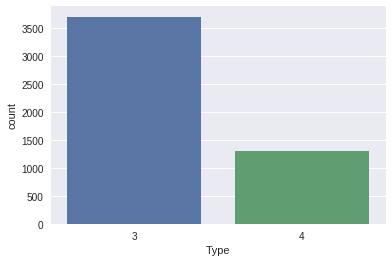

In [39]:
sns.countplot(data.Type)

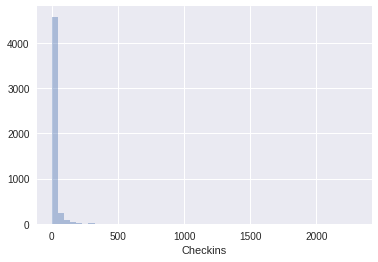

In [41]:
sns.distplot(data.Checkins, kde=False)

In [51]:
def is_third_type(row):
    if row.Type == 3:
        return row.Checkins

def is_thourth_type(row):
    if row.Type == 4:
        return row.Checkins

In [55]:
third_type_checkins = data[data['Type'].isin([3])].Checkins
thourth_type_checkins = data[data['Type'].isin([4])].Checkins

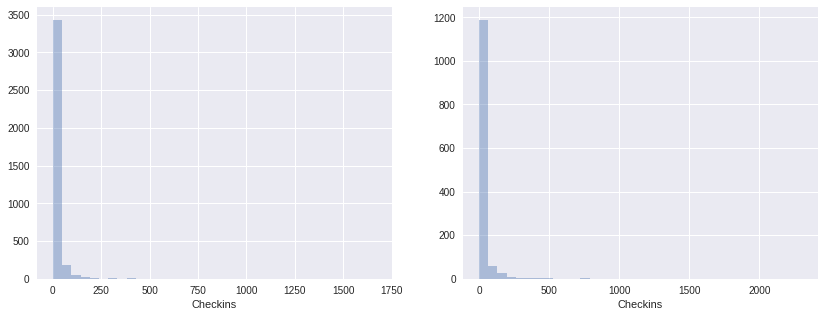

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
n_bins = 35

sns.distplot(third_type_checkins, kde=False, bins=n_bins, ax=axes[0])

sns.distplot(thourth_type_checkins, kde=False, bins=n_bins, ax=axes[1])

5. Преобразуйте поле created в datetime. Как давно были созданы объекты? Сколько объектов существует больше года?

In [64]:
data.Created
creation_times = [datetime.datetime.fromtimestamp(time) for time in data.Created]
print min(creation_times), max(creation_times)

2010-08-02 13:39:01 2010-08-02 13:41:18


Все объекты были созданы более шести лет назад с незначительной разницей в две минуты восемнадцать секунд. Все соданы более года назад.